In [7]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.signal as signal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import warnings
import sys, os

warnings.filterwarnings('ignore')
random_state = 6
np.random.seed(random_state)

In [8]:
dir_path = '../../pipeline_modules/'
sys.path.append(dir_path)

In [82]:
import visuals as vs
filename = 'seismogram_data_cents_db.csv'
df = pd.read_csv(filename)
viz = vs.vizualization(df)

## Basic statistics

In [4]:
df.describe()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211
count,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,...,1606.000000,1606.000000,1606.000000,1606.0,1606.000000,1606.000000,1.606000e+03,1.606000e+03,1606.000000,1606.000000
mean,451.221669,941.665095,75.003741,9.231527,50.089629,9.011473,33.163889,11.137501,21.313839,13.738046,...,-79.980776,-79.979309,-79.978603,0.0,278.243072,-0.188070,3.743952e+12,5.021586e+17,31.972242,0.323163
std,302.649662,225.061154,37.099307,35.261332,19.673425,23.210687,12.591131,14.331587,7.673028,8.545568,...,0.190952,0.217414,0.185078,0.0,7662.201633,4.893058,2.781032e+13,4.202786e+18,763.247083,0.467830
min,0.000000,487.638894,0.590916,-95.650386,9.991572,-63.162621,5.273298,-38.585637,0.495500,-20.883890,...,-80.000008,-80.000008,-80.000008,0.0,-18424.601562,-148.536407,1.145826e+00,1.647420e+08,-1.557898,0.000000
25%,200.250000,775.150225,46.703585,-14.839313,36.362204,-7.899532,24.523875,2.047651,16.663696,9.773171,...,-80.000000,-80.000000,-80.000000,0.0,-0.564912,-0.066578,1.089125e+05,4.726152e+10,-0.056514,0.000000
50%,401.000000,900.926968,74.069958,12.228716,49.900223,12.684427,31.645115,14.229327,20.592639,15.489321,...,-80.000000,-80.000000,-80.000000,0.0,0.114271,-0.004160,1.769261e+06,7.682032e+11,0.241702,0.000000
75%,684.750000,1095.790912,100.281783,35.329806,63.719153,28.028384,40.849423,22.416433,25.514643,19.247300,...,-80.000000,-80.000000,-80.000000,0.0,2.218386,0.057529,6.593582e+08,8.217131e+14,1.950677,1.000000
max,1086.000000,1572.073401,202.898203,98.485401,123.096246,64.457973,81.809122,47.306912,52.774850,39.409499,...,-73.452782,-72.382477,-74.135483,0.0,300014.312500,11.173301,3.098055e+14,6.909585e+19,27426.243439,1.000000


In [6]:
# viz.check_datatype()

# Data Quality checks

### Visualize missing data

In [9]:
if (viz.check_null()):
    viz.check_missing_value(start=50, end=100)
else:
    print('Looks like there is no any missing value')

False
Looks like there is no any missing value


### Check class balance 

[ 0.  1.] [1087  519]


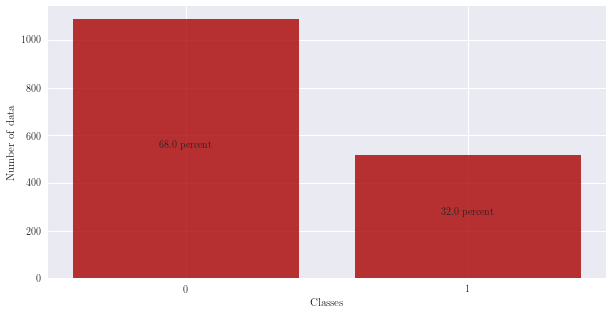

In [10]:
viz.check_data_balance(target_column = -1)

### Show correlation among the features

In [12]:
# plt.imshow(df.corr())
# plt.colorbar()
# plt.grid('off')
# plt.show()

### Calculate PCA and see if the data are distinguishable

In [112]:
X = df.iloc[:,:df.shape[1]-1]
Y = df.iloc[:,-1]

X, Y = shuffle(X, Y, random_state = random_state)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state=random_state)
mms = StandardScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.fit_transform(X_test)

## Bias-Variance tradeoff : Learning Curves 

## Validation Curves for Assessing Meta Parameter Values

## Grid search for four algorithoms :
1. Random Forest classifier
2. Xgboot
3. LightGBM
4. Support vector machine

In [35]:
%reload_ext autoreload
%autoreload 2
import gridsearch as gs
mgs = gs.GridSearch(X_train, Y_train)

In [ ]:
# perfomr grid search for the above algorithoms
mgs.create_gridclfs()

In [121]:
import lightgbm as lgb

lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.5,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=10, min_split_gain=0.0,
        n_estimators=10, n_jobs=-1, num_leaves=20, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1)
lgbm_model.fit(X_train, Y_train)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.5,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=10, min_split_gain=0.0,
        n_estimators=10, n_jobs=-1, num_leaves=20, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

In [122]:
Y_pred = lgbm_model.predict(X_test)

print('1. The accuracy of the model is {}\n'.format(accuracy_score(Y_test, Y_pred)))
print('2. Classification report \n {} \n'.format(classification_report(Y_test, Y_pred)))
print('3. Confusion matrix \n {} \n'.format(confusion_matrix(Y_pred, Y_test)))
print('4. Roc_Auc score \n {}'.format(roc_auc_score(Y_pred, Y_test)))

1. The accuracy of the model is 0.7885572139303483

2. Classification report 
              precision    recall  f1-score   support

        0.0       0.77      0.98      0.86       276
        1.0       0.90      0.37      0.52       126

avg / total       0.81      0.79      0.76       402
 

3. Confusion matrix 
 [[271  80]
 [  5  46]] 

4. Roc_Auc score 
 0.8370202781967487


## Xgboost model

In [40]:
import xgboost as xgb 
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.10, max_delta_step=0,
       max_depth=5, min_child_weight=11, missing=-999, n_estimators=2000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=1,
       subsample=0.8)

xgb_model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=11, missing=-999, n_estimators=2000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1337, silent=1,
       subsample=0.8)

In [41]:
Y_pred = xgb_model.predict(X_test)

print('1. The accuracy of the model is {}\n'.format(accuracy_score(Y_test, Y_pred)))
print('2. Classification report \n {} \n'.format(classification_report(Y_test, Y_pred)))
print('3. Confusion matrix \n {} \n'.format(confusion_matrix(Y_pred, Y_test)))
print('4. Roc_Auc score \n {}'.format(roc_auc_score(Y_pred, Y_test)))

1. The accuracy of the model is 0.8606965174129353

2. Classification report 
              precision    recall  f1-score   support

        0.0       0.88      0.92      0.90       276
        1.0       0.81      0.73      0.77       126

avg / total       0.86      0.86      0.86       402
 

3. Confusion matrix 
 [[254  34]
 [ 22  92]] 

4. Roc_Auc score 
 0.8444809941520467


## Random forest classifier

In [64]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
rfc = RandomForestClassifier(criterion='entropy', random_state = random_state, class_weight='balanced')
params = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [10, 20, 40, 50]
}

grid_clf = GridSearchCV(estimator = rfc, param_grid = params, scoring = 'accuracy', cv = cv)

In [65]:
# we have to find out best optimized parameters
grid_clf.fit(X_train, Y_train.astype(int))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=6, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 50, 100], 'max_depth': [1, 2, 3, 4, 5], 'min_samples_split': [10, 20, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [128]:
class_weight = {0:1, 1:2}
model = RandomForestClassifier(bootstrap=True, class_weight=class_weight,
            criterion='entropy', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=random_state, verbose=0, warm_start=False)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

print('1. The accuracy of the model is {}\n'.format(accuracy_score(Y_test, Y_pred)))
print('2. Classification report \n {} \n'.format(classification_report(Y_test, Y_pred)))
print('3. Confusion matrix \n {} \n'.format(confusion_matrix(Y_pred, Y_test)))
print('4. Roc_Auc score \n {}'.format(roc_auc_score(Y_pred, Y_test)))

1. The accuracy of the model is 0.8009950248756219

2. Classification report 
              precision    recall  f1-score   support

        0.0       0.91      0.79      0.84       276
        1.0       0.64      0.83      0.72       126

avg / total       0.83      0.80      0.81       402
 

3. Confusion matrix 
 [[217  21]
 [ 59 105]] 

4. Roc_Auc score 
 0.7760043041606886


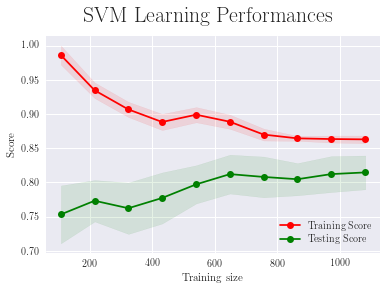

In [129]:
%reload_ext autoreload
%autoreload 2
import visuals as vs
vz = vs.vizualization(df)
vz.check_model_learning(X_train, Y_train, model)

# Support Vector machine 

In [67]:
from sklearn import svm
class_weight={0: 1, 1: 2}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = random_state)
svm_clss = svm.SVC(class_weight = class_weight, random_state = random_state) 

svm_params = {
    'C': [100, 200, 250, 300, 350, 400], 
    'gamma': [0.0003566], 
    'kernel': ['rbf']
}

grid_clf = GridSearchCV(estimator = svm_clss, param_grid = svm_params, scoring = 'accuracy', cv = cv)

In [68]:
grid_clf.fit(X_train, Y_train.astype(int))

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=6, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [100, 200, 250, 300, 350, 400], 'gamma': [0.0003566], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [69]:
print(grid_clf.best_params_)
print(grid_clf.best_score_)
print(grid_clf.best_estimator_)

{'C': 100, 'gamma': 0.0003566, 'kernel': 'rbf'}
0.910299003322
SVC(C=100, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0003566, kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False)


In [132]:
svm_model = svm.SVC(C=200, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0003566, kernel='rbf',
  max_iter=-1, probability=False, random_state=random_state, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)

print('1. The accuracy of the model is {}\n'.format(accuracy_score(Y_test, Y_pred)))
print('2. Classification report \n {} \n'.format(classification_report(Y_test, Y_pred)))
print('3. Confusion matrix \n {} \n'.format(confusion_matrix(Y_pred, Y_test)))
print('4. Roc_Auc score \n {}'.format(roc_auc_score(Y_pred, Y_test)))

1. The accuracy of the model is 0.927860696517413

2. Classification report 
              precision    recall  f1-score   support

        0.0       0.95      0.94      0.95       276
        1.0       0.88      0.90      0.89       126

avg / total       0.93      0.93      0.93       402
 

3. Confusion matrix 
 [[260  13]
 [ 16 113]] 

4. Roc_Auc score 
 0.9141749723145072


## Learning curve to check if more data is required to improve performance

In this step of the project, I will check the learning curve of the support vector machine. A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data. If the training score is much higher than the validation score for the maximum number of training samples, adding more training samples will most likely increase generalization. In the following plot of SVM estimator, we see that the model could benefit from more training examples. We have to add training data to get improved performance.

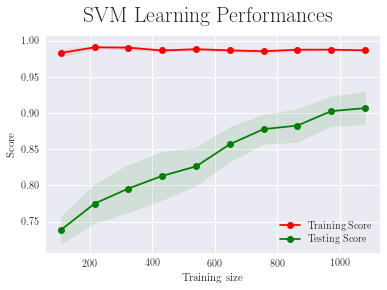

In [127]:
%reload_ext autoreload
%autoreload 2
import visuals as vs
vz = vs.vizualization(df)
vz.check_model_learning(X_train, Y_train, svm_model)

## Bagging of SVM

In [139]:
from sklearn.ensemble import BaggingClassifier
bagging_svm = BaggingClassifier(svm_model, max_samples=0.4, n_estimators=20, n_jobs=-1)
bagging_svm.fit(X_train, Y_train.astype(int))

BaggingClassifier(base_estimator=SVC(C=200, cache_size=200, class_weight={0: 1, 1: 2}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0003566, kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.4, n_estimators=20, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [140]:
Y_pred = bagging_svm.predict(X_test)

print('1. The accuracy of the model is {}\n'.format(accuracy_score(Y_test, Y_pred)))
print('2. Classification report \n {} \n'.format(classification_report(Y_test, Y_pred)))
print('3. Confusion matrix \n {} \n'.format(confusion_matrix(Y_pred, Y_test)))
print('4. Roc_Auc score \n {}'.format(roc_auc_score(Y_pred, Y_test)))

1. The accuracy of the model is 0.8805970149253731

2. Classification report 
              precision    recall  f1-score   support

        0.0       0.91      0.92      0.91       276
        1.0       0.81      0.80      0.81       126

avg / total       0.88      0.88      0.88       402
 

3. Confusion matrix 
 [[253  25]
 [ 23 101]] 

4. Roc_Auc score 
 0.8622940357391505
